In [57]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# 데이터 읽어오기

In [58]:
# 데이터 불러오기
sentence_token_df = pd.read_csv('sentence_token.csv')
document_token_df = pd.read_csv('document_token.csv')

In [59]:
# 데이터 합치기
data = pd.concat([sentence_token_df, document_token_df])

## 감성분석 도전 1

In [60]:
# KoBERT 모델 및 토크나이저 불러오기
model_name = 'monologg/kobert'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
# 감정 분석 함수 정의
def analyze_sentiment(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    sentiment = torch.argmax(logits, dim=1).item()
    return sentiment

In [62]:
# 데이터프레임에 감정 분석 결과 추가
data['sentiment'] = data['contents'].apply(analyze_sentiment)

In [63]:
# 컬림이름 확인차
print(data.columns)

Index(['file', 'sequence', 'talker', 'time', 'talk_time', 'contents', 'stage',
       'stage_detail', 'scale', 'token_noun', 'token_all',
       'token_noun_stopwords', 'token_all_stopwords', 'token', 'sentiment'],
      dtype='object')


In [64]:
# 코치와 코치이의 데이터 분리
coach_data = data[data['talker'] == '코치']
coachee_data = data[data['talker'] == '코치이']

In [65]:
# 시간 순서대로 정렬
coach_data = coach_data.sort_values(by='time')
coachee_data = coachee_data.sort_values(by='time')

In [66]:
plt.figure(figsize=(14, 7))

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

Text(0, 0.5, 'Sentiment')

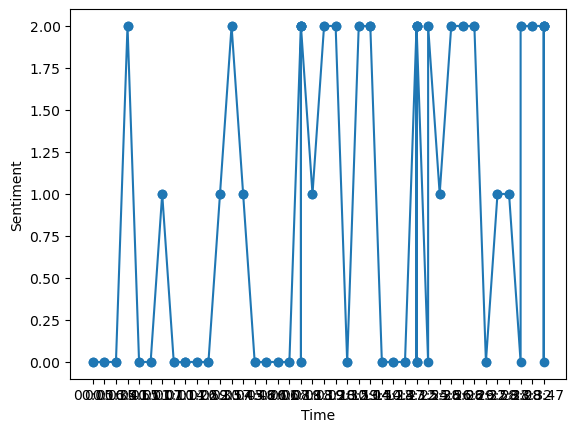

In [67]:
# 코치 감정 변화 선그래프
plt.plot(coach_data['time'], coach_data['sentiment'], label='코치', marker='o')
plt.xlabel('Time')
plt.ylabel('Sentiment')

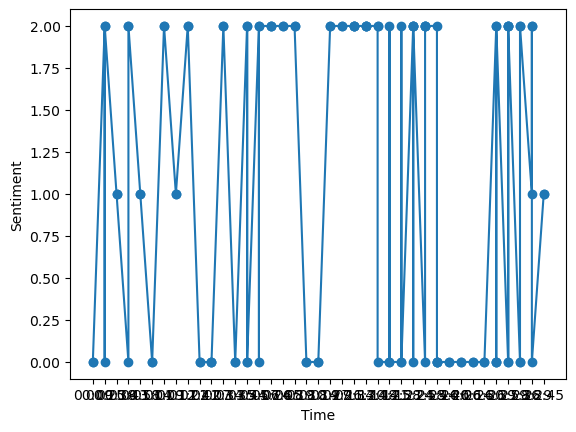

In [68]:
# 코치이 감정 변화 선그래프
plt.plot(coachee_data['time'], coachee_data['sentiment'], label='코치이', marker='o')
plt.xlabel('Time')
plt.ylabel('Sentiment')
plt.show()

/opt/anaconda3/envs/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


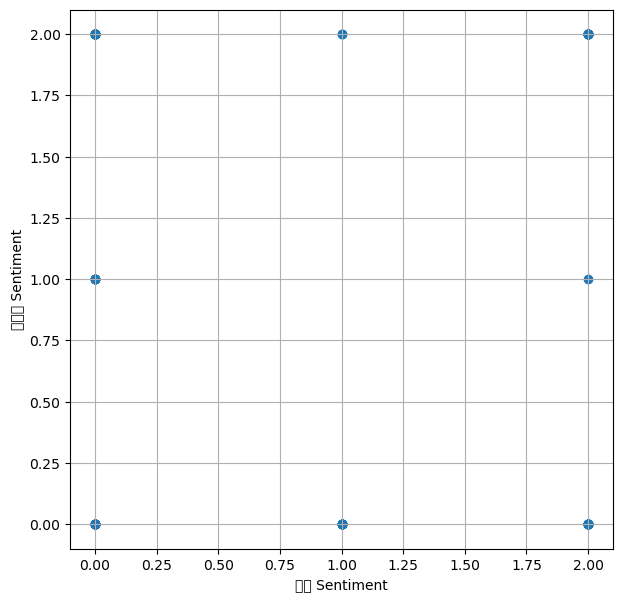

In [71]:
# 산점도
# 두 데이터프레임에서 동일한 크기로 설정
min_len = min(len(coach_data), len(coachee_data))
coach_sentiments = coach_data['sentiment'].values[:min_len]
coachee_sentiments = coachee_data['sentiment'].values[:min_len]
plt.figure(figsize=(7, 7))
plt.scatter(coach_sentiments, coachee_sentiments)
plt.xlabel('코치 Sentiment')
plt.ylabel('코치이 Sentiment')
plt.grid(True)
plt.show()

In [72]:
# 상관계수 계산
correlation = np.corrcoef(coach_sentiments, coachee_sentiments)[0, 1]
print(f'코치와 코치이의 감정 상관계수: {correlation}')

코치와 코치이의 감정 상관계수: -0.09866616936358993


#### 도전 1을 통해 알아낸것
- 0,1,2 이렇게 너무 단순하게 하다보니 결과값이 이상한것같다,
- 0-1 사이로 하고, 감정분석을 조금더 디테일하게 해볼것

## 감성분석 도전 2

In [76]:
# 열 이름 확인
print(data.columns)

Index(['file', 'sequence', 'talker', 'time', 'talk_time', 'contents', 'stage',
       'stage_detail', 'scale', 'token_noun', 'token_all',
       'token_noun_stopwords', 'token_all_stopwords', 'token', 'sentiment'],
      dtype='object')


In [77]:
# 위에 데이터 불러오기와 같은 작업

import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np
import matplotlib.pyplot as plt

# 데이터 불러오기
sentence_token_df = pd.read_csv('sentence_token.csv')
document_token_df = pd.read_csv('document_token.csv')

# 데이터 합치기
data = pd.concat([sentence_token_df, document_token_df])

# 열 이름 확인
print(data.columns)

# KoBERT 모델 및 토크나이저 불러오기
model_name = 'monologg/kobert'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# 감정 분석 함수 정의
def analyze_sentiment(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    positive_score = probabilities[0][1].item()
    return positive_score


Index(['file', 'sequence', 'talker', 'time', 'talk_time', 'contents', 'stage',
       'stage_detail', 'scale', 'token_noun', 'token_all',
       'token_noun_stopwords', 'token_all_stopwords', 'token'],
      dtype='object')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [78]:
data['sentiment'] = data['contents'].apply(analyze_sentiment)
print(data.sentiment)

0     0.495082
1     0.503200
2     0.497098
3     0.529788
4     0.495872
        ...   
74    0.488937
75    0.530755
76    0.494233
77    0.481934
78    0.512656
Name: sentiment, Length: 211, dtype: float64


In [97]:
data

,file,sequence,talker,time,talk_time,contents,stage,stage_detail,scale,token_noun,token_all,token_noun_stopwords,token_all_stopwords,token,sentiment
0,(1순위 추천) 1차녹음(김희준),1,코치,00:05,4.000000,우진다님이 우리 쪽에 온 지가 언제고,전반,0.224593,문장,"['우진', '우리', '언제']","['우진', '다니다', '우리', '지다', '언제']","['우진', '언제']","['우진', '다니다', '지다', '언제']","['우진다님이', '우리', '쪽에', '온', '지가', '언제고']",0.495082
1,(1순위 추천) 1차녹음(김희준),2,코치이,00:09,7.000000,지금 사무실 들어온 건 21년도에 4월쯤에 들어가서,전반,0.617631,문장,"['지금', '사무실']","['지금', '사무실', '들어오다', '들어가다']","['지금', '사무실']","['지금', '사무실', '들어오다', '들어가다']","['지금', '사무실', '들어온', '건', '21년도에', '4월쯤에', '들어...",0.503200
2,(1순위 추천) 1차녹음(김희준),3,코치,00:16,9.000000,21년 4월에 그러면 가공 현장에서는,전반,1.122965,문장,"['가공', '현장']","['그러면', '가공', '현장']","['가공', '현장']","['가공', '현장']","['21년', '4월에', '그러면', '가공', '현장에서는']",0.497098
3,(1순위 추천) 1차녹음(김희준),4,코치이,00:25,5.666667,17년도 2월 입사니까 18 19 22 한 4년 정도 했고요.,전반,1.441138,문장,"['입사', '정도']","['입사', '하다', '정도', '하다']","['입사', '정도']","['입사', '정도', '하다']","['17년도', '2월', '입사니까', '18', '19', '22', '한', ...",0.529788
4,(1순위 추천) 1차녹음(김희준),4,코치이,00:25,4.333333,지금 사무실 와서 24 24 3년 정도 했고요.,전반,1.684447,문장,"['지금', '사무실', '정도']","['지금', '사무실', '오다', '정도', '하다']","['지금', '사무실', '정도']","['지금', '사무실', '오다', '정도', '하다']","['지금', '사무실', '와서', '24', '24', '3년', '정도', '했...",0.495872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,(1순위 추천) 1차녹음(김희준),75,코치,28:08,21.000000,그래 맞다 앞으로도 그런 비슷한 일이 매 년마다 생길 거야.\n매 연마다 매년마다 ...,후반,95.676586,문단,"['연마', '매년', '이제', '결혼']","['그렇다', '맞다', '그렇다', '비슷하다', '생기다', '연마', '매년'...","['연마', '매년', '이제', '결혼']","['맞다', '그렇다', '비슷하다', '생기다', '연마', '매년', '생기다'...","['그래', '맞다', '앞으로도', '그런', '비슷한', '일이', '매', '...",0.488937
75,(1순위 추천) 1차녹음(김희준),76,코치이,28:29,3.000000,아니요. 결혼한 지는 좀 됐습니다. 18년도 됐으니까,후반,95.845031,문단,['결혼'],"['아니다', '결혼', '지다', '돼다', '돼다']",['결혼'],"['아니다', '결혼', '지다', '돼다', '돼다']","['아니요', '결혼한', '지는', '좀', '됐습니다', '18년도', '됐으니까']",0.530755
76,(1순위 추천) 1차녹음(김희준),77,코치,28:32,13.000000,그러면 68년 7년 6~7년 차 7년 7년 차 정도 이제 곱하기 2만 하면 그렇게 ...,후반,96.574958,문단,"['정도', '이제', '곱하기', '트러블', '이제', '얼마']","['그러면', '정도', '이제', '곱하기', '하다', '그렇게', '크다', ...","['정도', '이제', '곱하기', '트러블', '이제']","['정도', '이제', '곱하기', '하다', '그렇게', '트러블', '없다', ...","['그러면', '68년', '7년', '67년', '차', '7년', '7년', '...",0.494233
77,(1순위 추천) 1차녹음(김희준),78,코치이,28:45,2.000000,많이 남아,후반,96.687254,문단,['남아'],"['많이', '남아']",['남아'],"['많이', '남아']","['많이', '남아']",0.481934


In [79]:
# 코치와 코치이의 데이터 분리
coach_data = data[data['talker'] == '코치']
coachee_data = data[data['talker'] == '코치이']

/opt/anaconda3/envs/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


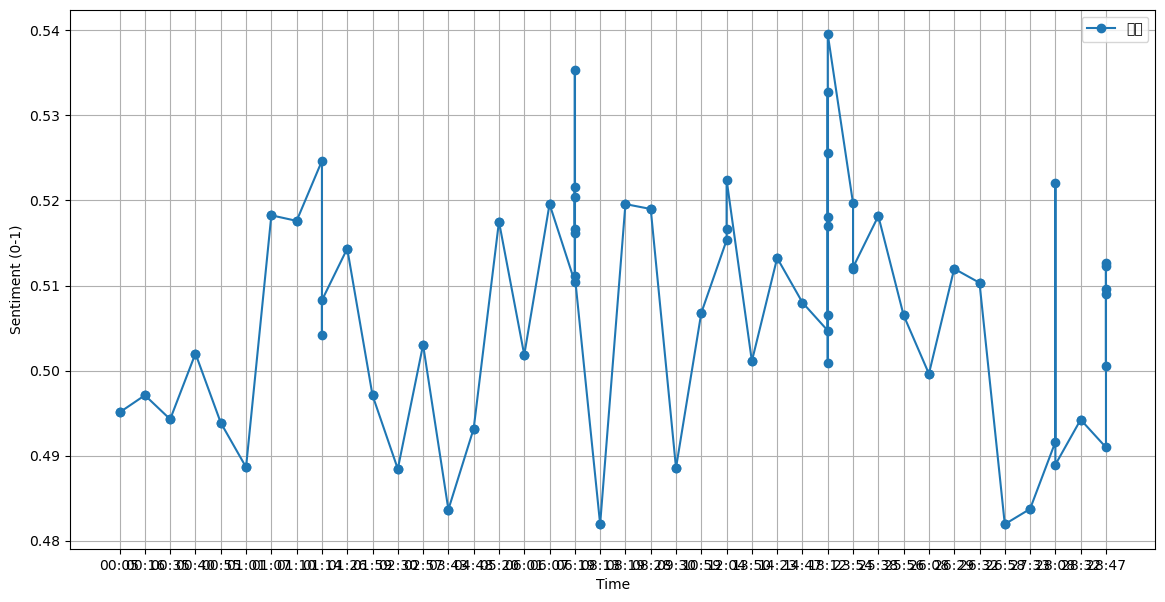

In [84]:
# 시간 순서대로 정렬
coach_data = coach_data.sort_values(by='time')
coachee_data = coachee_data.sort_values(by='time')

# 감정 변화 추이 시각화
plt.figure(figsize=(14, 7))

# 코치 감정 변화 선그래프
plt.plot(coach_data['time'], coach_data['sentiment'], label='코치', marker='o')
plt.xlabel('Time')
plt.ylabel('Sentiment (0-1)')
plt.legend()
plt.grid(True)
plt.show()

/opt/anaconda3/envs/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


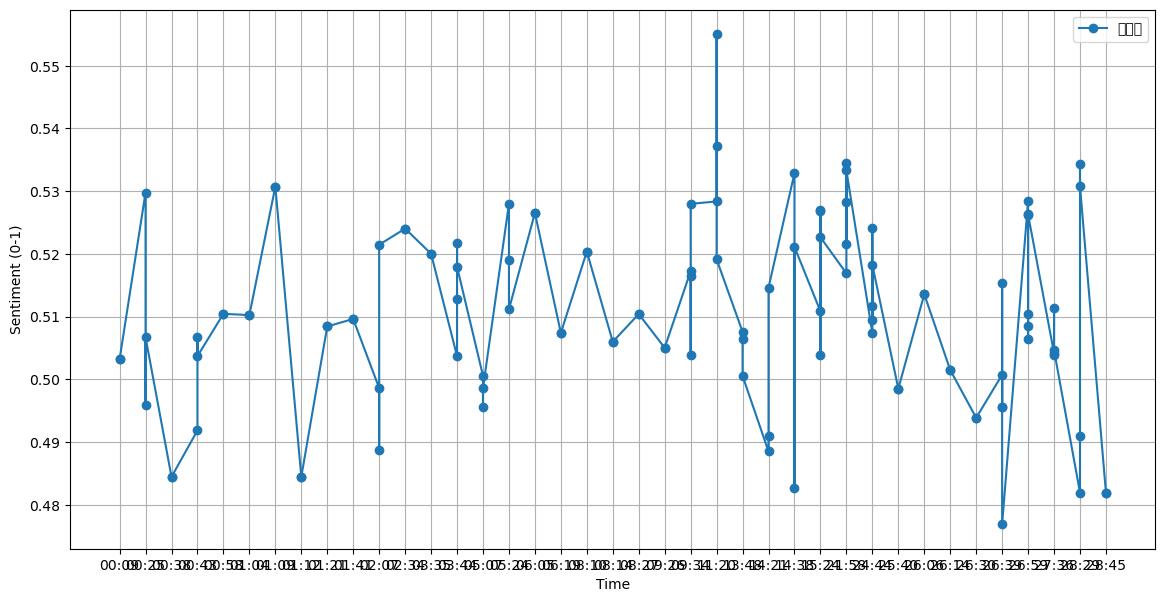

In [85]:
# 코치이 감정 변화 선그래프
plt.figure(figsize=(14, 7))
plt.plot(coachee_data['time'], coachee_data['sentiment'], label='코치이', marker='o')

plt.xlabel('Time')
plt.ylabel('Sentiment (0-1)')
plt.legend()
plt.grid(True)
plt.show()

/opt/anaconda3/envs/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


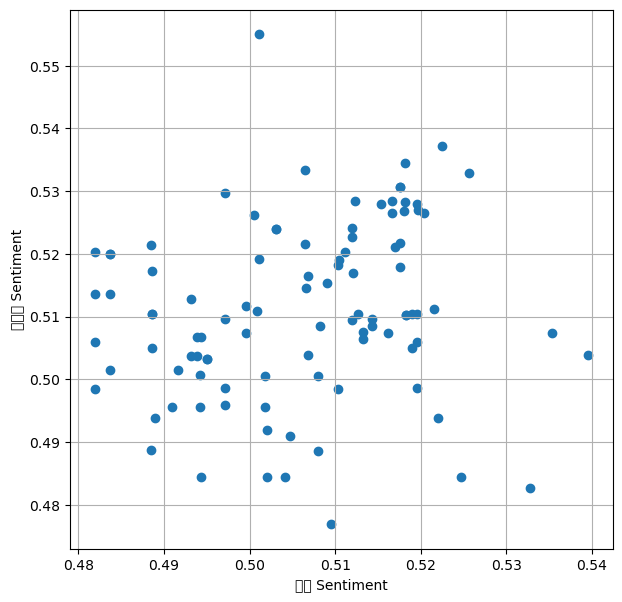

In [86]:
# 산점도
# 두 데이터프레임에서 동일한 크기로 설정
min_len = min(len(coach_data), len(coachee_data))
coach_sentiments = coach_data['sentiment'].values[:min_len]
coachee_sentiments = coachee_data['sentiment'].values[:min_len]

plt.figure(figsize=(7, 7))
plt.scatter(coach_sentiments, coachee_sentiments)
plt.xlabel('코치 Sentiment')
plt.ylabel('코치이 Sentiment')
plt.grid(True)
plt.show()

In [87]:
# 상관계수 계산
correlation = np.corrcoef(coach_sentiments, coachee_sentiments)[0, 1]
print(f'코치와 코치이의 감정 상관계수: {correlation}')

코치와 코치이의 감정 상관계수: 0.1762837065180818


In [103]:
# 데이터 자체를 좀 찾아보자
print(data.iloc[7,:])

file                        (1순위 추천) 1차녹음(김희준)
sequence                                                     7
talker                                                      코치
time                                                     00:40
talk_time                                                  3.0
contents                                  거의 가공 가공이 가공 가공 이겠네.
stage                                                       전반
stage_detail                                          2.133633
scale                                                       문장
token_noun                      ['거의', '가공', '가공', '가공', '가공']
token_all                ['거의', '가공', '가공', '가공', '가공', '이겠다']
token_noun_stopwords                  ['가공', '가공', '가공', '가공']
token_all_stopwords            ['가공', '가공', '가공', '가공', '이겠다']
token                   ['거의', '가공', '가공이', '가공', '가공', '이겠네']
sentiment                                             0.502006
Name: 7, dtype: object


### 도전2 를 통해 알게된것
- 0~1 사이로 줄이고, 결과를 보니 아까보다는 그래도 상관계수 자체는 올라감, 하지만 결과값이 너무 미미하다.
- 가지고 있는 데이터 자체를 둘러 본 결과, 긍정인지 부정인지 감정을 알기에는 부족한 부분들이 많다.
- 감성분석에 있어서는 데이터적인 문제가 크지않나. 그리하여 결과값이 잘 도출되지 않았을 부분또한 고려해야한다. 

# 알고리즘 구현

### 1. TXT 파일을 읽어 정리된 데이터프레임을 생성한다.

In [1]:
import pandas as pd
import os
import re
from datetime import datetime, timedelta

In [128]:
# 데이터를 가져올 디렉토리를 지정합니다.
directory = 'C/Users/chaerin/Library/CloudStorage/OneDrive-Lab4DX/Documents - Lab4DX/인사이트랩/2024년/6. 한스코칭'  # 여기를 원하는 디렉토리 경로로 변경하세요.

In [129]:
# 텍스트 파일 패턴을 분석하는 함수입니다.
def parse_text(file_path, file_name):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    
    # 'clovanote.naver.com' 제거
    content = content.replace('clovanote.naver.com', '')
    
    # 정규 표현식을 사용하여 필요한 정보를 추출합니다.
    pattern = re.compile(r'(\w+\s*\d*)\s(\d{2}:\d{2})\n(.*?)(?=\n\w+\s*\d*\s\d{2}:\d{2}|$)', re.DOTALL)
    matches = pattern.findall(content)
    
    sequence = 1

    for match in matches:
        talker, time_str, contents = match
        
        # time_str을 타임스탬프로 변환
        timestamp = datetime.strptime(time_str, '%M:%S')
        
        # time_str 포맷 변경
        time_formatted = timestamp.strftime('%M:%S')
        
        df.loc[len(df)] = [file_name, talker, time_formatted, contents.strip(), sequence, 0]
        
        sequence += 1

In [130]:
# talk_time을 계산하는 함수입니다.
def calculate_talk_time(df):
    updated_rows = []
    for file in df['file'].unique():
        file_df = df[df['file'] == file].reset_index(drop=True)
        for i in range(len(file_df) - 1):
            talk_time_sec = (datetime.strptime(file_df.at[i+1, 'time'], '%M:%S') - datetime.strptime(file_df.at[i, 'time'], '%M:%S')).total_seconds()
            file_df.at[i, 'talk_time'] = int(talk_time_sec)
            updated_rows.append(file_df.iloc[i])
        
        # 마지막 row의 talk_time 계산
        last_row = file_df.iloc[-1]
        same_talker_rows = file_df[(file_df['file'] == last_row['file']) & (file_df['talker'] == last_row['talker'])]
        total_contents_length = same_talker_rows['contents'].apply(len).sum()
        total_talk_time = same_talker_rows['talk_time'].sum()
        
        if total_contents_length > 0 and total_talk_time > 0:
            last_talk_time = (len(last_row['contents']) / total_contents_length) * total_talk_time
            file_df.at[len(file_df)-1, 'talk_time'] = int(last_talk_time)
        
        updated_rows.append(file_df.iloc[-1])
    
    updated_df = pd.DataFrame(updated_rows).reset_index(drop=True)
    return updated_df

In [131]:
# 같은 talker의 연속된 row를 묶는 함수입니다.
def group_talkers(df):
    grouped_data = []
    for file in df['file'].unique():
        file_df = df[df['file'] == file].reset_index(drop=True)
        new_sequence = 1
        grouped_row = file_df.iloc[0].copy()
        grouped_row['sequence'] = new_sequence
        for i in range(1, len(file_df)):
            current_row = file_df.iloc[i]
            if current_row['talker'] == grouped_row['talker']:
                grouped_row['contents'] += " " + current_row['contents']
                grouped_row['time'] = min(grouped_row['time'], current_row['time'])  # time을 가장 작은 값으로 설정
                grouped_row['talk_time'] += current_row['talk_time'] if current_row['talk_time'] is not None else 0
            else:
                grouped_data.append(grouped_row.copy())
                new_sequence += 1
                grouped_row = current_row.copy()
                grouped_row['sequence'] = new_sequence
                grouped_row['talk_time'] = current_row['talk_time'] if current_row['talk_time'] is not None else 0
        
        grouped_data.append(grouped_row)
    
    grouped_df = pd.DataFrame(grouped_data).reset_index(drop=True)

    # sequence 다시 설정
    grouped_df['sequence'] = range(1, len(grouped_df) + 1)

    return grouped_df

In [132]:
# 결과를 저장할 빈 데이터프레임을 생성합니다.
df = pd.DataFrame(columns=['file', 'talker', 'time', 'contents', 'sequence', 'talk_time'])

In [122]:
# 디렉토리 내의 모든 텍스트 파일을 처리합니다.
for file in os.listdir(directory):
    if file.endswith('.txt'):
        file_path = os.path.join(directory, file)
        file_name = file[:-4]  # .txt를 제외한 파일 이름
        parse_text(file_path, file_name)

NameError: name 'os' is not defined

In [8]:
# talk_time 계산
df = calculate_talk_time(df)

df

,file,talker,time,contents,sequence,talk_time
0,(1순위 추천) 1차녹음(김희준),코치,00:05,우진다님이 우리 쪽에 온 지가 언제고,1,4
1,(1순위 추천) 1차녹음(김희준),코치이,00:09,지금 사무실 들어온 건 21년도에 4월쯤에 들어가서,2,7
2,(1순위 추천) 1차녹음(김희준),코치,00:16,21년 4월에,3,6
3,(1순위 추천) 1차녹음(김희준),코치,00:22,그러면 가공 현장에서는,4,3
4,(1순위 추천) 1차녹음(김희준),코치이,00:25,17년도 2월 입사니까 18 19 22 한 4년 정도 했고요.\n지금 사무실 와서 ...,5,10
...,...,...,...,...,...,...
86,(1순위 추천) 1차녹음(김희준),코치이,28:29,아니요. 결혼한 지는 좀 됐습니다. 18년도 됐으니까,87,3
87,(1순위 추천) 1차녹음(김희준),코치,28:32,그러면 68년 7년 6~7년 차 7년 7년 차 정도 이제 곱하기 2만 하면 그렇게 ...,88,13
88,(1순위 추천) 1차녹음(김희준),코치이,28:45,많이 남아,89,2
89,(1순위 추천) 1차녹음(김희준),코치,28:47,아니다. 아니다 전혀 마,90,7


In [121]:
# 같은 talker의 연속된 row 묶기
df_raw = group_talkers(df)

# 컬럼 순서 재정렬
df_raw = df_raw[['file', 'sequence', 'talker', 'time', 'talk_time', 'contents']]

df_raw

KeyError: "['file', 'talker', 'time', 'talk_time', 'contents'] not in index"

### 2. 분석용 데이터프레임을 생성한다. (파일당 3개)

In [10]:
# talk_time의 누적 합계 계산
df_raw['cumulative_talk_time'] = df_raw['talk_time'].cumsum()

# 전체 talk_time 합계 계산
total_talk_time = df_raw['talk_time'].sum()

# stage 및 stage_detail 컬럼 추가
def determine_stage(cumulative, total):
    percentage = (cumulative / total) * 100
    if percentage <= 10:
        stage = '전반'
    elif percentage <= 90:
        stage = '중반'
    else:
        stage = '후반'
    return stage, percentage

df_raw[['stage', 'stage_detail']] = df_raw['cumulative_talk_time'].apply(lambda x: pd.Series(determine_stage(x, total_talk_time)))

# 필요 없는 누적 합계 컬럼 제거
df_raw.drop(columns=['cumulative_talk_time'], inplace=True)

In [11]:
df_raw

,file,sequence,talker,time,talk_time,contents,stage,stage_detail
0,(1순위 추천) 1차녹음(김희준),1,코치,00:05,4,우진다님이 우리 쪽에 온 지가 언제고,전반,0.224593
1,(1순위 추천) 1차녹음(김희준),2,코치이,00:09,7,지금 사무실 들어온 건 21년도에 4월쯤에 들어가서,전반,0.617631
2,(1순위 추천) 1차녹음(김희준),3,코치,00:16,9,21년 4월에 그러면 가공 현장에서는,전반,1.122965
3,(1순위 추천) 1차녹음(김희준),4,코치이,00:25,10,17년도 2월 입사니까 18 19 22 한 4년 정도 했고요.\n지금 사무실 와서 ...,전반,1.684447
4,(1순위 추천) 1차녹음(김희준),5,코치,00:35,3,그럼 현장에서는 어떤 일 했지,전반,1.852892
...,...,...,...,...,...,...,...,...
74,(1순위 추천) 1차녹음(김희준),75,코치,28:08,21,그래 맞다 앞으로도 그런 비슷한 일이 매 년마다 생길 거야.\n매 연마다 매년마다 ...,후반,95.676586
75,(1순위 추천) 1차녹음(김희준),76,코치이,28:29,3,아니요. 결혼한 지는 좀 됐습니다. 18년도 됐으니까,후반,95.845031
76,(1순위 추천) 1차녹음(김희준),77,코치,28:32,13,그러면 68년 7년 6~7년 차 7년 7년 차 정도 이제 곱하기 2만 하면 그렇게 ...,후반,96.574958
77,(1순위 추천) 1차녹음(김희준),78,코치이,28:45,2,많이 남아,후반,96.687254


### 문장 단위로 구분하기

In [12]:
# 한글 문장 단위로 분리하는 함수
def split_sentences(contents):
    return re.split(r'(?<=[.!?])\s+', contents)

# 각 문장의 비율로 talk_time 나누기
def distribute_talk_time(talk_time, sentences):
    total_length = sum(len(sentence) for sentence in sentences)
    return [talk_time * (len(sentence) / total_length) for sentence in sentences]

In [13]:
# 새로운 데이터프레임 생성
df_raw_sentence = pd.DataFrame(columns=df_raw.columns)

# 데이터 변환
rows_list = []
for idx, row in df_raw.iterrows():
    sentences = split_sentences(row['contents'])
    talk_times = distribute_talk_time(row['talk_time'], sentences)
    
    for sentence, talk_time in zip(sentences, talk_times):
        new_row = row.copy()
        new_row['contents'] = sentence
        new_row['talk_time'] = talk_time
        rows_list.append(new_row)

# FutureWarning 해결을 위해 빈 데이터프레임을 미리 만들어 놓고 concat 시 사용
df_new_rows = pd.DataFrame(rows_list)
df_raw_sentence = pd.concat([df_raw_sentence, df_new_rows], ignore_index=True)

# stage_detail 계산
df_raw_sentence['cumulative_talk_time'] = df_raw_sentence['talk_time'].cumsum()
total_talk_time = df_raw_sentence['talk_time'].sum()
df_raw_sentence['stage_detail'] = (df_raw_sentence['cumulative_talk_time'] / total_talk_time) * 100

# 필요한 열만 유지
df_raw_sentence = df_raw_sentence.drop(columns=['cumulative_talk_time'])

C:\Users\박시은\AppData\Local\Temp\ipykernel_29208\3774878037.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_raw_sentence = pd.concat([df_raw_sentence, df_new_rows], ignore_index=True)


In [14]:
df_raw_sentence

,file,sequence,talker,time,talk_time,contents,stage,stage_detail
0,(1순위 추천) 1차녹음(김희준),1,코치,00:05,4.000000,우진다님이 우리 쪽에 온 지가 언제고,전반,0.224593
1,(1순위 추천) 1차녹음(김희준),2,코치이,00:09,7.000000,지금 사무실 들어온 건 21년도에 4월쯤에 들어가서,전반,0.617631
2,(1순위 추천) 1차녹음(김희준),3,코치,00:16,9.000000,21년 4월에 그러면 가공 현장에서는,전반,1.122965
3,(1순위 추천) 1차녹음(김희준),4,코치이,00:25,5.666667,17년도 2월 입사니까 18 19 22 한 4년 정도 했고요.,전반,1.441138
4,(1순위 추천) 1차녹음(김희준),4,코치이,00:25,4.333333,지금 사무실 와서 24 24 3년 정도 했고요.,전반,1.684447
...,...,...,...,...,...,...,...,...
127,(1순위 추천) 1차녹음(김희준),79,코치,28:47,0.911197,아니다.,후반,96.738416
128,(1순위 추천) 1차녹음(김희준),79,코치,28:47,30.069498,아니다 전혀 마 그래 그 제발 좀 지치지 말고 아까 이야기했는 그런 것들 얼마만큼 ...,후반,98.426766
129,(1순위 추천) 1차녹음(김희준),79,코치,28:47,13.667954,그려보고 난 다음에 뭐 힘든 거 있으면 바로바로 조용히 이야기해 주고 내가 도와줄 ...,후반,99.194197
130,(1순위 추천) 1차녹음(김희준),79,코치,28:47,11.845560,그리고 우리 팀에서 제일 잘생기고 일 잘하는 사람으로 기억될 수 있도록 좀 더 노력...,후반,99.859304


In [15]:
# scale 컬럼 추가
df_raw['scale'] = '문단'
df_raw_sentence['scale'] = '문장'

### 조합에 대한 그룹화

In [16]:
# 모든 조합에 대해 그룹화
df_group = pd.DataFrame()
grouped = df_raw.groupby(['file', 'talker', 'stage','scale']).agg({
    'talk_time': 'sum',
    'contents': ' '.join
}).reset_index()

df_group = pd.concat([grouped], ignore_index=True)

In [17]:
df_group

,file,talker,stage,scale,talk_time,contents
0,(1순위 추천) 1차녹음(김희준),코치,전반,문단,63,우진다님이 우리 쪽에 온 지가 언제고 21년 4월에 그러면 가공 현장에서는 그럼 현...
1,(1순위 추천) 1차녹음(김희준),코치,중반,문단,770,지금은 우진사님이 이제 사무실 와가 이제 약재나 각종 현장 챙기고 하는 거 하고 공...
2,(1순위 추천) 1차녹음(김희준),코치,후반,문단,97,3개 나오셨네 응 그렇지 그게 놀러 가는 게 아니 그래 맞다 앞으로도 그런 비슷한 ...
3,(1순위 추천) 1차녹음(김희준),코치이,전반,문단,109,지금 사무실 들어온 건 21년도에 4월쯤에 들어가서 17년도 2월 입사니까 18 1...
4,(1순위 추천) 1차녹음(김희준),코치이,중반,문단,652,그러니까 이제 저는 이제 항상 이제 좀 다 이제 뭐라 하지 잘하고 싶다 욕심일 수도...
5,(1순위 추천) 1차녹음(김희준),코치이,후반,문단,90,그렇죠 그래서 이제 아니요. 그러니까 대놓고 얘기하더라고요.\n그러니까 대놓고 얘기...


In [18]:
# talker와 stage의 '전체' 그룹핑 추가 함수
def add_overall_groups(df):
    # talker의 전체 그룹핑
    overall_talker = df.groupby(['file', 'scale', 'stage']).agg({
        'talk_time': 'sum',
        'contents': ' '.join
    }).reset_index()
    overall_talker['talker'] = '전체'

    # stage의 전체 그룹핑
    overall_stage = df.groupby(['file', 'scale', 'talker']).agg({
        'talk_time': 'sum',
        'contents': ' '.join
    }).reset_index()
    overall_stage['stage'] = '전체'

    # 두 그룹 결합
    df_group_final = pd.concat([df, overall_talker, overall_stage], ignore_index=True).drop_duplicates()
    return df_group_final

# 전체 그룹핑 결과 생성
df_group_final = add_overall_groups(df_group)
df_group_final

,file,talker,stage,scale,talk_time,contents
0,(1순위 추천) 1차녹음(김희준),코치,전반,문단,63,우진다님이 우리 쪽에 온 지가 언제고 21년 4월에 그러면 가공 현장에서는 그럼 현...
1,(1순위 추천) 1차녹음(김희준),코치,중반,문단,770,지금은 우진사님이 이제 사무실 와가 이제 약재나 각종 현장 챙기고 하는 거 하고 공...
2,(1순위 추천) 1차녹음(김희준),코치,후반,문단,97,3개 나오셨네 응 그렇지 그게 놀러 가는 게 아니 그래 맞다 앞으로도 그런 비슷한 ...
3,(1순위 추천) 1차녹음(김희준),코치이,전반,문단,109,지금 사무실 들어온 건 21년도에 4월쯤에 들어가서 17년도 2월 입사니까 18 1...
4,(1순위 추천) 1차녹음(김희준),코치이,중반,문단,652,그러니까 이제 저는 이제 항상 이제 좀 다 이제 뭐라 하지 잘하고 싶다 욕심일 수도...
5,(1순위 추천) 1차녹음(김희준),코치이,후반,문단,90,그렇죠 그래서 이제 아니요. 그러니까 대놓고 얘기하더라고요.\n그러니까 대놓고 얘기...
6,(1순위 추천) 1차녹음(김희준),전체,전반,문단,172,우진다님이 우리 쪽에 온 지가 언제고 21년 4월에 그러면 가공 현장에서는 그럼 현...
7,(1순위 추천) 1차녹음(김희준),전체,중반,문단,1422,지금은 우진사님이 이제 사무실 와가 이제 약재나 각종 현장 챙기고 하는 거 하고 공...
8,(1순위 추천) 1차녹음(김희준),전체,후반,문단,187,3개 나오셨네 응 그렇지 그게 놀러 가는 게 아니 그래 맞다 앞으로도 그런 비슷한 ...
9,(1순위 추천) 1차녹음(김희준),코치,전체,문단,930,우진다님이 우리 쪽에 온 지가 언제고 21년 4월에 그러면 가공 현장에서는 그럼 현...


In [19]:
# talker와 stage의 '전체' 그룹핑 추가 함수
def add_overall_groups(df):
    # talker의 전체 그룹핑
    overall_talker = df.groupby(['file', 'scale', 'stage']).agg({
        'talk_time': 'sum',
        'contents': ' '.join
    }).reset_index()
    overall_talker['talker'] = '전체'

    # stage의 전체 그룹핑
    overall_stage = df.groupby(['file', 'scale', 'talker']).agg({
        'talk_time': 'sum',
        'contents': ' '.join
    }).reset_index()
    overall_stage['stage'] = '전체'

    # stage와 talker의 전체 그룹핑
    overall_all = df.groupby(['file', 'scale']).agg({
        'talk_time': 'sum',
        'contents': ' '.join
    }).reset_index()
    overall_all['talker'] = '전체'
    overall_all['stage'] = '전체'

    # 세 그룹 결합
    df_group_final = pd.concat([df, overall_talker, overall_stage, overall_all], ignore_index=True).drop_duplicates()
    return df_group_final

# 전체 그룹핑 결과 생성
df_group_final = add_overall_groups(df_group)

df_group_final

,file,talker,stage,scale,talk_time,contents
0,(1순위 추천) 1차녹음(김희준),코치,전반,문단,63,우진다님이 우리 쪽에 온 지가 언제고 21년 4월에 그러면 가공 현장에서는 그럼 현...
1,(1순위 추천) 1차녹음(김희준),코치,중반,문단,770,지금은 우진사님이 이제 사무실 와가 이제 약재나 각종 현장 챙기고 하는 거 하고 공...
2,(1순위 추천) 1차녹음(김희준),코치,후반,문단,97,3개 나오셨네 응 그렇지 그게 놀러 가는 게 아니 그래 맞다 앞으로도 그런 비슷한 ...
3,(1순위 추천) 1차녹음(김희준),코치이,전반,문단,109,지금 사무실 들어온 건 21년도에 4월쯤에 들어가서 17년도 2월 입사니까 18 1...
4,(1순위 추천) 1차녹음(김희준),코치이,중반,문단,652,그러니까 이제 저는 이제 항상 이제 좀 다 이제 뭐라 하지 잘하고 싶다 욕심일 수도...
5,(1순위 추천) 1차녹음(김희준),코치이,후반,문단,90,그렇죠 그래서 이제 아니요. 그러니까 대놓고 얘기하더라고요.\n그러니까 대놓고 얘기...
6,(1순위 추천) 1차녹음(김희준),전체,전반,문단,172,우진다님이 우리 쪽에 온 지가 언제고 21년 4월에 그러면 가공 현장에서는 그럼 현...
7,(1순위 추천) 1차녹음(김희준),전체,중반,문단,1422,지금은 우진사님이 이제 사무실 와가 이제 약재나 각종 현장 챙기고 하는 거 하고 공...
8,(1순위 추천) 1차녹음(김희준),전체,후반,문단,187,3개 나오셨네 응 그렇지 그게 놀러 가는 게 아니 그래 맞다 앞으로도 그런 비슷한 ...
9,(1순위 추천) 1차녹음(김희준),코치,전체,문단,930,우진다님이 우리 쪽에 온 지가 언제고 21년 4월에 그러면 가공 현장에서는 그럼 현...


In [20]:
df_group = df_group_final
df_docu_source = df_raw
df_sent_source = df_raw_sentence

### 3. 토큰화를 수행한다.

In [21]:
from konlpy.tag import Okt

# 형태소 분석기 객체 생성
okt = Okt()

# stopwords 파일 읽기
with open('ko-stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = set(f.read().splitlines())

# stopwords 제거 함수
def remove_stopwords(text):
    words = text.split()
    return ' '.join([word for word in words if word not in stopwords and len(word) > 1])

# 명사만 추출하는 함수
def stopwords_extract_nouns(text):
    text = remove_stopwords(text) # stopwords 및 1글자 단어 제거
    pos_words = okt.pos(text, stem=True, norm=True)
    words = [word for word, tag in pos_words if tag in ['Noun'] if len(word) > 1]
    return words

# 명사, 동사, 형용사, 부사 추출하는 함수
def stopwords_extract_all(text):
    text = remove_stopwords(text)  # stopwords 및 1글자 단어 제거
    pos_words = okt.pos(text, stem=True, norm=True)
    words = [word for word, tag in pos_words if tag in ['Noun', 'Verb', 'Adjective', 'Adverb'] if len(word) > 1]
    return words

AttributeError: Java package 'kr.lucypark.okt' is not valid

In [ ]:
# 형태소 분석기 객체 생성
okt = Okt()

# 명사만 추출하는 함수
def extract_nouns(text):
    pos_words = okt.pos(text, stem=True, norm=True)
    words = [word for word, tag in pos_words if tag in ['Noun'] if len(word) > 1]
    return words

# 명사, 동사, 형용사, 부사 추출하는 함수
def extract_all(text):
    pos_words = okt.pos(text, stem=True, norm=True)
    words = [word for word, tag in pos_words if tag in ['Noun', 'Verb', 'Adjective', 'Adverb'] if len(word) > 1]
    return words

In [ ]:
import re 

def tokenize_text(text):
    # 기호를 제거합니다.
    text = re.sub(r'[^\w\s]', '', text)
    
    # 공백으로 단어를 나눕니다.
    tokens = text.split()
    
    return tokens

In [ ]:
# 각 contents에 대해 형태소 분석 수행
dataframes = [df_group, df_docu_source, df_sent_source]  # df_group과 유사한 여러 데이터프레임을 리스트로 만듭니다.

def process_dataframe(df):
    df_return['token_noun'] = df['contents'].apply(extract_nouns)
    df_return['token_all'] = df['contents'].apply(extract_all)
    df_return['token_noun_stopwords'] = df['contents'].apply(stopwords_extract_nouns)
    df_return['token_all_stopwords'] = df['contents'].apply(stopwords_extract_all)
    df_return['token'] = df['contents'].apply(tokenize_text)
    return df_return

df_group = process_dataframe(df_group)
df_docu_source = process_dataframe(df_docu_source)
df_sent_source = process_dataframe(df_sent_source)

### 형태소 분석 컬럼 추가

In [39]:
df_group.to_csv('group_token.csv', encoding='utf-8-sig', index=False)